In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

In [3]:
#Get the data
classes = 10 
images = []
labels = [] 

for i in range(0, classes):
    imgList = os.listdir('Data/'+str(i))
    for j in imgList:
        currentImg = cv2.imread('Data/'+str(i)+'/'+str(j))
        currentImg = cv2.resize(currentImg, (28, 28))
        images.append(currentImg)
        labels.append(i)
        
print(len(images))
print(len(labels))

10160
10160


In [4]:
images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)

(10160, 28, 28, 3)
(10160,)


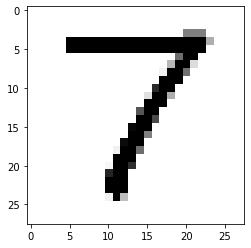

In [5]:
plt.imshow(images[8000])

Splitting ito train test


In [6]:

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)
print(train_images.shape)
print(test_images.shape)

(8128, 28, 28, 3)
(2032, 28, 28, 3)


In [7]:

train_images,  val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)
print(train_images.shape)
print(val_images.shape)



(6502, 28, 28, 3)
(1626, 28, 28, 3)


## Preprocessing


In [8]:
def preProcess(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.equalizeHist(img)
    x,img=cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img=img/255
    return img

train_images = np.array(list(map(preProcess, train_images)))
test_images = np.array(list(map(preProcess, test_images)))
val_images = np.array(list(map(preProcess, val_images)))

In [9]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(6502, 28, 28)
(2032, 28, 28)
(1626, 28, 28)


In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
val_images = val_images.reshape(val_images.shape[0], 28, 28, 1)

In [11]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(6502, 28, 28, 1)
(2032, 28, 28, 1)
(1626, 28, 28, 1)


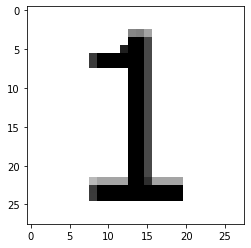

In [12]:
plt.imshow(images[2000])

In [12]:
# Creating Callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.995):
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

## CNN


In [13]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28, 28, 1),  activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Conv2D(64, (3,3),  activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Conv2D(64, (3,3),  activation="relu"),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation="relu"),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(10,activation=tf.nn.softmax)
])

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          3

#### Image Augmentation


In [15]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

#### Model Training

In [16]:
callbacks = myCallback()
history = model.fit(datagen.flow(train_images, train_labels),
                              epochs = 30, validation_data = (val_images, val_labels), callbacks = [callbacks])

Epoch 1/30
204/204 [==============================] - 5s 23ms/step - loss: 2.2300 - accuracy: 0.1578 - val_loss: 0.5522 - val_accuracy: 0.8641
Epoch 2/30
204/204 [==============================] - 4s 17ms/step - loss: 0.9965 - accuracy: 0.6632 - val_loss: 0.1688 - val_accuracy: 0.9569
Epoch 3/30
204/204 [==============================] - 4s 17ms/step - loss: 0.5271 - accuracy: 0.8387 - val_loss: 0.0836 - val_accuracy: 0.9729
Epoch 4/30
204/204 [==============================] - 3s 17ms/step - loss: 0.4066 - accuracy: 0.8645 - val_loss: 0.0567 - val_accuracy: 0.9809
Epoch 5/30
204/204 [==============================] - 3s 17ms/step - loss: 0.2961 - accuracy: 0.9049 - val_loss: 0.0581 - val_accuracy: 0.9803
Epoch 6/30
204/204 [==============================] - 4s 17ms/step - loss: 0.2552 - accuracy: 0.9168 - val_loss: 0.0390 - val_accuracy: 0.9871
Epoch 7/30
204/204 [==============================] - 3s 17ms/step - loss: 0.2464 - accuracy: 0.9232 - val_loss: 0.0453 - val_accuracy: 0.9865

#### Plotting results of training

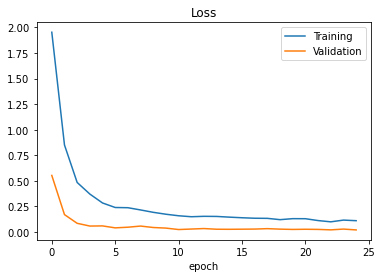

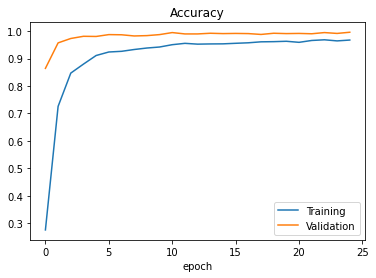

In [17]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training','Validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

#### Evaualting model


In [18]:
score = model.evaluate(test_images, test_labels, verbose=1)
print('Test Score : ', score[0])
print('Test Accuracy : ', score[1])

64/64 [==============================] - 0s 4ms/step - loss: 0.0150 - accuracy: 0.9946
Test Score :  0.014966894872486591
Test Accuracy :  0.9945865869522095


#### Saving Model

In [19]:
model.save('Digit_Identification')
model.save("Digit_Identification.h5")

INFO:tensorflow:Assets written to: Digit_Identification\assets
